In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

In [3]:
kernel = nsx.AnnularKernel(data.nRows(), data.nCols())
convolver = nsx.Convolver()
convolver.setKernel(kernel.matrix())

finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationScale(3.0)
finder.setBackgroundScale(5.0)
finder.setSearchScale(1.0)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

peaks = finder.find([data])
print(len(peaks))

9200


In [4]:
for peak in peaks:
    peak.setSelected(True)

In [5]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.correctedIntensity().value()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1000.0:
        continue
        
    d = 1.0 / np.linalg.norm(peak.q().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))

7402


In [50]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

for i in range(len(indexer.getSolutions())):
    sln = indexer.getSolutions()[i]               
    ch = nsx.UnitCell(sln[0]).character()
    print("%3d %6.1f %6.1f %6.1f %6.3f %6.3f %6.3f %5.1f" % (i, ch.a, ch.b, ch.c, ch.alpha, ch.beta, ch.gamma, sln[1]))



auto indexing 7402 peaks
  0   54.6   58.3   67.3  1.571  1.571  1.571 100.0
  1   54.6   58.3  134.5  1.571  1.571  1.571 100.0
  2   86.7   58.3  128.2  1.571  1.701  1.571 100.0
  3  104.3  123.8  134.8  1.991  1.733  1.771 100.0
  4   89.1  104.3  140.9  1.438  1.481  1.450  99.9
  5   89.1  104.3  123.8  1.371  1.257  1.450  99.9
  6  109.2   58.3  145.2  1.571  1.186  1.571  99.9
  7   88.9  123.8  145.4  1.524  1.395  1.257  99.9
  8   86.6   58.3  128.3  1.571  1.700  1.571  99.9
  9  109.2   67.3  128.8  1.571  1.133  1.571  99.9
 10   58.3   67.3  109.2  1.571  1.571  1.571  99.9
 11   54.6   67.3  116.6  1.571  1.571  1.571  99.9
 12   86.6  104.4  128.8  1.284  1.303  1.401  99.9
 13  128.3   58.3  145.2  1.571  1.404  1.571  99.9
 14   88.9  104.5  123.8  1.372  1.257  1.449  99.9
 15   79.9   86.7  104.4  1.400  1.521  1.127  99.9
 16  134.5  109.2   58.3  1.571  1.571  1.571  99.9
 17  104.4  134.8  177.0  1.379  1.328  1.409  99.9
 18  128.2   58.3  145.2  1.571  1.404 

In [51]:
best_cell = 0
soln = indexer.getSolutions()[best_cell]

uc = nsx.UnitCell(soln[0])
sample = diff.sample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = nsx.MillerIndex(peak.q(), uc)
    if np.linalg.norm(hkl.error()) < 0.2:
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

indexed 7390 of 7402
found unit cell with parameters: 
a:  54.60469754025093
b:  58.34182178442945
c:  67.27107633458675
alpha:  1.5707963267948966
beta:  1.5707963267948966
gamma:  1.5707963267948966


In [52]:
refiner = nsx.Refiner(uc, peaks, int(data.nFrames()/5))
refiner.refineKi(data.instrumentStates())
refiner.refineSampleOrientation(data.instrumentStates())
refiner.refineSamplePosition(data.instrumentStates())

success = refiner.refine()
print(success)

True


In [89]:

def get_zone_data(h, k, l):
    bzone = nsx.BrillouinZone(uc.reciprocalBasis())
    events = []
    counts = []
    hkl = np.array([h, k, l], dtype=np.float).reshape(1,3)
    q = hkl.dot(uc.reciprocalBasis())    
    hull = bzone.detectorConvexHull(nsx.ReciprocalVector(q), data)
    bb = hull.aabb()
    lb = bb.lower().reshape(3)
    ub = bb.upper().reshape(3)
    xmin = int(lb[0])
    ymin = int(lb[1])
    zmin = int(lb[2])
    
    xmax = int(ub[0]+1)
    ymax = int(ub[1]+1)
    zmax = int(ub[2]+1)
    
    for z in range(zmin, zmax):
        frame = data.transformedFrame(z)
        
        for x in range(xmin, xmax):
            for y in range(ymin, ymax):
                ev = nsx.DetectorEvent(x, y, z)
                vec = np.array([x, y, z], dtype=np.float).reshape(3,1)
                if not hull.contains(vec):
                    continue
                events.append(ev)
                counts.append(frame[y, x])
    
    return events, counts, 1/np.linalg.norm(q)

def get_gaussian(h, k, l)
    bzone = nsx.BrillouinZone(uc.reciprocalBasis())
    events = []
    counts = []
    hkl = np.array([h, k, l], dtype=np.float).reshape(1,3)
    q = hkl.dot(uc.reciprocalBasis())    
    hull = bzone.detectorConvexHull(nsx.ReciprocalVector(q), data)
    bb = hull.aabb()
    lb = bb.lower().reshape(3)
    ub = bb.upper().reshape(3)
    xmin = int(lb[0])
    ymin = int(lb[1])
    zmin = int(lb[2])
    
    xmax = int(ub[0]+1)
    ymax = int(ub[1]+1)
    zmax = int(ub[2]+1)
    
    for z in range(zmin, zmax):
        frame = data.transformedFrame(z)
        
        for x in range(xmin, xmax):
            for y in range(ymin, ymax):
                ev = nsx.DetectorEvent(x, y, z)
                vec = np.array([x, y, z], dtype=np.float).reshape(3,1)
                if not hull.contains(vec):
                    continue
                events.append(ev)
                counts.append(frame[y, x])
                
                
    mx = sum(x) / len(x)
    my = sum(y) / len(y)
    mz = sum(z) / len(z)
    
    center = np.array([mx, my, mz]).reshape(3,1)
    pred = nsx.Peak3D(data, nsx.Ellipsoid(center, 1.0))
    cov = lib.predictCovariance(pred)
    
    return 
    


[-2.98884122 16.97519095 -6.96069511]
[[  2.63018164  58.27394555   0.1558534 ]
 [-14.23138825   0.86389234 -64.93854312]
 [-52.65190145   2.67752295  17.56015485]]
[[  2.63018164  58.27394555   0.1558534 ]
 [-14.23138825   0.86389234 -64.93854312]
 [-52.65190145   2.67752295  17.56015485]]
d = 3.182195021776997


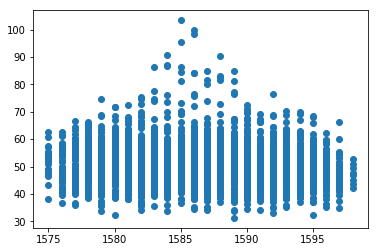

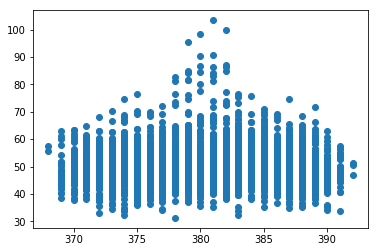

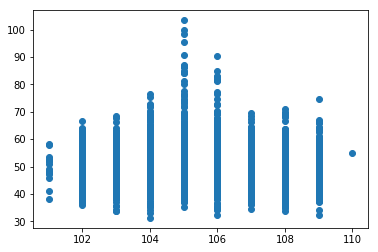

In [168]:
import random
pk, = random.sample(peaks, 1)
hkl = pk.activeUnitCell().index(pk.q()).reshape(3)

print(hkl)
h = int(round(hkl[0]))
k = int(round(hkl[1]))
l = int(round(hkl[2]))

print(peak.activeUnitCell().basis())
print(uc.basis())

events, counts, d = get_zone_data(-h, k, l)
print("d =", d)

x = [ ev._px for ev in events ]
y = [ ev._py for ev in events ]
z = [ ev._frame for ev in events ]

plt.scatter(x, counts)
plt.show()

plt.scatter(y, counts)
plt.show()

plt.scatter(z, counts)
plt.show()


d = 5.611220866405851


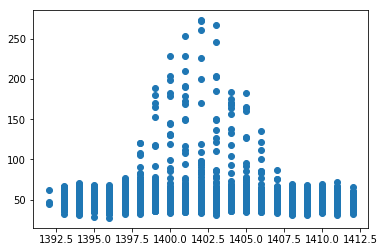

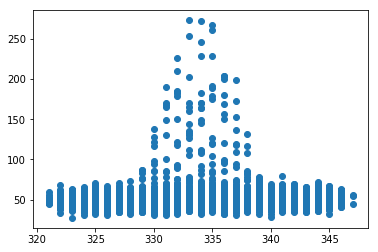

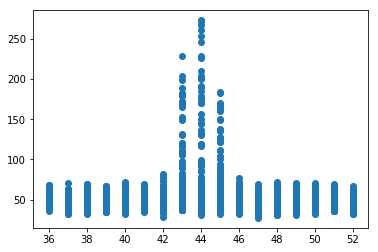

[[ 8.04795433 -0.8743961  -0.01041898]
 [-0.8743961   8.10088041 -0.02605434]
 [-0.01041898 -0.02605434  0.05348169]]
[[ 8.52297013 -1.40978517  6.26417222]
 [-1.40978517  7.81585949 -4.31435665]
 [ 6.26417222 -4.31435665 14.79543619]]


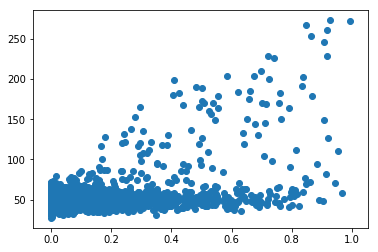

362.0500090152249
375.0414092310904


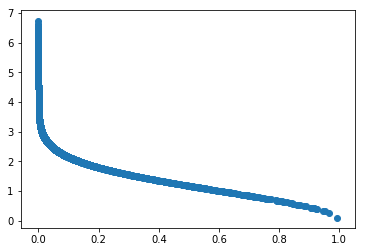

In [171]:
events, counts, d = get_zone_data(6, 8, -2)
print("d =", d)

x = [ ev._px for ev in events ]
y = [ ev._py for ev in events ]
z = [ ev._frame for ev in events ]

plt.scatter(x, counts)
plt.show()

plt.scatter(y, counts)
plt.show()

plt.scatter(z, counts)
plt.show()

center = np.array([sum(x)/len(x), sum(y)/len(y), sum(z)/len(z)]).reshape(3,1)
pred = nsx.Peak3D(data, nsx.Ellipsoid(center, 1.0))
cov1 = lib.predictCovariance(pred)


cov2 = lib.meanCovariance(pred, 400, 10)

print(cov1)
print(cov2)

A = np.linalg.inv(cov2)


r = []
g = []

for ev in events:
    vec = np.array([ev._px, ev._py, ev._frame]).reshape(3,1)
    dx = vec-center
    s = np.sqrt(dx.transpose().dot(A).dot(dx).trace())
    r.append(s)
    g.append(np.exp(-s*s/2.0))
    
plt.scatter(g, counts)
plt.show()
print(sum(g))
coef = np.sqrt(np.linalg.det(A)) / np.sqrt(2*np.pi)**3
print(1.0 / coef)

plt.scatter(g, r)
plt.show()

In [95]:
lower = np.array([-1.0, -1.0, -1.0])
upper = np.array([1.0, 1.0, 1.0])

peak_list = nsx.PeakList()
for p in good_peaks:
    peak_list.push_back(p)

si = nsx.ShapeIntegrator(nsx.AABB(lower, upper), 10, 10, 10, False)
si.integrate(peak_list, data, 4.0, 4.5, 5.0)

In [129]:
lib = si.library()
lib.updateFit(100)
lib.meanPearson()

0.9755451935871401

[[9.86700291e+02 3.21287058e+02 6.51542221e-01]]


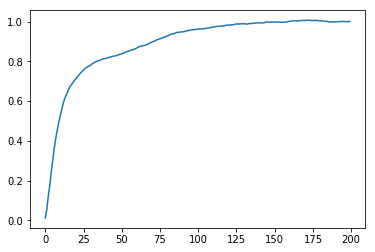

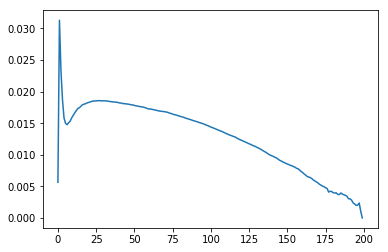

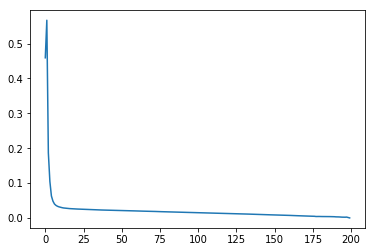

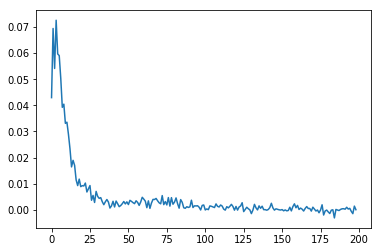

In [37]:
p, = random.sample(good_peaks, 1)
c = p.getShape().center()
ev = nsx.DetectorEvent(c)

prof = lib.meanIntegratedProfile(ev, 500, 10)

vals = np.array([ b.value() for b in prof ])
sigs = np.array([ b.sigma() for b in prof ])


print(c.transpose())

plt.plot(vals)
plt.show()

plt.plot(sigs)
plt.show()

plt.plot(sigs/vals)
plt.show()

dval = [ vals[i] - vals[i-1] for i in range(1, len(vals))]
plt.plot(dval)
plt.show()

[[1563.8170058   514.54903111   12.0560746 ]]


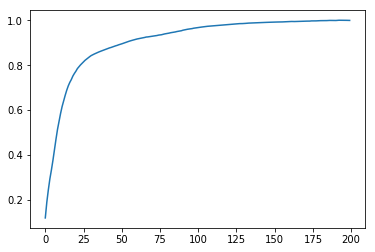

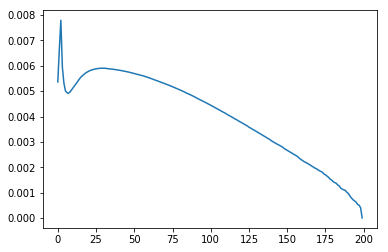

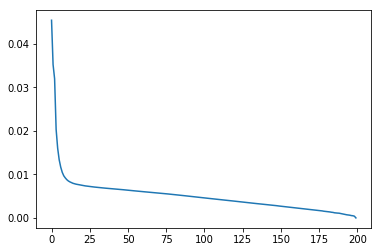

In [48]:
import random
p, = random.sample(good_peaks, 1)
ev = nsx.DetectorEvent(p.getShape().center())
profile = lib.meanIntegratedProfile(ev, 300, 10)

print(p.getShape().center().transpose())

vs = np.array([pr.value() for pr in profile])
ss = np.array([pr.sigma() for pr in profile])

plt.plot(vs)
plt.show()

plt.plot(ss)
plt.show()

plt.plot(ss/vs)
plt.show()

In [49]:
handler = nsx.ProgressHandler()

class TestIntegrator(nsx.StrongPeakIntegrator):
    def __init__(self):
        nsx.StrongPeakIntegrator.__init__(self)
        self.data = []
        self.count = 0
        
    def compute(self, peak, region):
        #s = nsx.StrongPeakIntegrator()
        #s.compute(peak, region)
        #self._integratedIntensity = s._integratedIntensity
        #self._meanBackground = s._meanBackground
        profile = nsx.IntegratedProfile()
        
        if (self.count%200 == 0):
            print(self.count)
            
        self.count += 1
        
        events = region.data().events()
        counts = region.data().counts()
        
        sh = peak.getShape()
        x0 = sh.center()
        A = sh.metric()
        
        for i in range(len(events)):
            x = np.array([events[i]._px, events[i]._py, events[i]._frame]).reshape(3,1)
            dx = x-x0
            rr = dx.transpose().dot(A).dot(dx).trace()
            profile.addPoint(rr, counts[i])                
        
        self.data.append((peak, profile))
        return True
    
peak_list = nsx.PeakList()

for p in good_peaks:
    peak_list.push_back(p)
        
ti = TestIntegrator()
ti.setHandler(handler)
ti.integrate(peak_list, data, 4.0, 5.0, 6.0)
print("done")

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
done


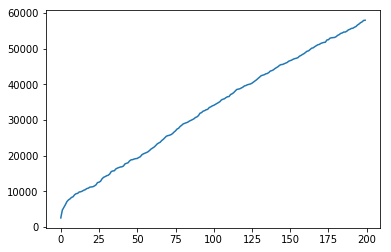

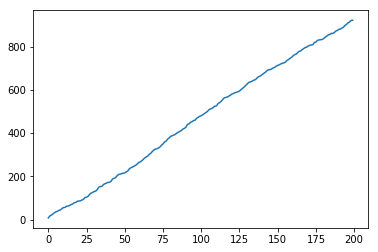

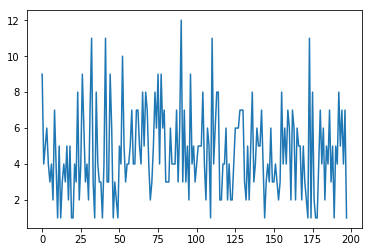

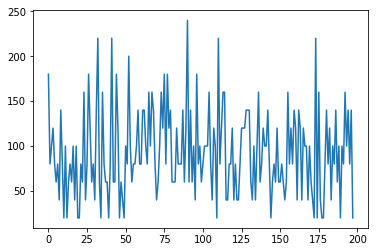

[2992.84141502   55.43295796]
[3787.75354786   54.46978276]
[3873.28804642   54.38802336]
[3880.8908753    54.38102203]
[3881.55317992   54.38041431]
[3881.61071024   54.38036151]
[3881.61570425   54.38035693]
[3881.61570425   54.38035693]
[3881.61570425   54.38035693]
[3881.61570425   54.38035693]
backround sub 0.0


In [105]:
from scipy.optimize import least_squares

(pk,pr), = random.sample(ti.data, 1)

vals = np.array(pr.counts())
nums = np.array(pr.npoints())

plt.plot(vals)
plt.show()

plt.plot(nums)
plt.show()

mean_prof = lib.meanIntegratedProfile(nsx.DetectorEvent(pk.getShape().center()), 500, 10)

p = np.array([ px.value() for px in mean_prof ])

dp = []
dn = []
dm = []

for i in range(1, len(p)):
    if nums[i] == nums[i-1]:
        continue
        
    dp.append(p[i]-p[i-1])
    dn.append(nums[i]-nums[i-1])
    dm.append(vals[i]-vals[i-1])

dp = np.array(dp)
dn = np.array(dn)
dm = np.array(dm)
    
B = 20
I = 0
wts = B*dn +dp*I


plt.plot(dn)
plt.show()

plt.plot(wts)
plt.show()

def residual(x):
    I, B = x    
    r = B*dn+I*dp - dm
    #r *= (wts>0)
    #wts += (wts<=0)
    r /= wts
    return r

for _ in range(10):   
    result = least_squares(residual, (I,B))
    I, B = result.x
    wts = B*dn + dp*I   

    
    print(result.x)

    
print("backround sub", pk.getRawIntensity().value())

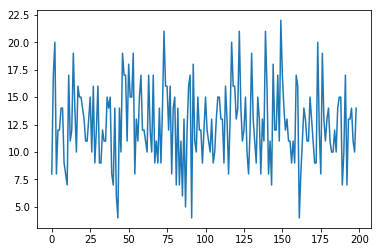

In [97]:
plt.plot(dn)
plt.show()

In [ ]:
class GaussianIntegrator(nsx.IPeakIntegrator):
    def __init__(self):
        nsx.IPeakIntegrator.__init__(self)
        self.data = []
        
    def compute(self, peak, region):
        #s = nsx.StrongPeakIntegrator()
        #s.compute(peak, region)
        #self._integratedIntensity = s._integratedIntensity
        #self._meanBackground = s._meanBackground
        self.data.append((peak, nsx.PeakData(region.peakData())))
        return True
    
peak_list = nsx.PeakList()

for p in good_peaks:
    peak_list.push_back(p)
        
g = GaussianIntegrator()
g.integrate(peak_list, data, 3.0, 4.0, 6.0)
print("done")

In [ ]:
help(nsx.ShapeIntegrator)

In [ ]:
images = [data.transformedFrame(i) for i in range(data.nFrames())]

In [ ]:
dx = 8
plt.imshow(images[0][450-dx:450+dx, 1250-dx:1250+dx])
plt.show()

baseline = np.array([im[450-dx:450+dx, 1250-dx:1250+dx] for im in images]).flatten()

print(baseline.mean())
print(baseline.std())


In [ ]:
data = np.array([im[700, 900] for im in images])
plt.plot(data)
plt.show()

gain = data.std()**2 / (data.mean() - baseline.mean())
print(gain)

In [ ]:
import random

p, = random.sample(good_peaks, 1)

hull = bzone.detectorConvexHull(p.q(), p.data())

c = p.getShape().center()
A = p.getShape().metric()
S = p.getShape().inverseMetric()

bb = hull.aabb()
lo = bb.lower()
hi = bb.upper()

sig_max = 6
sig_min = 4.5
dx = hi-c

lo = c - dx
hi = c + dx

print(lo, hi)

xmin = int(lo[0,0])-1
ymin = int(lo[1,0])-1
zmin = int(lo[2,0])-1

xmax = int(hi[0,0])+1
ymax = int(hi[1,0])+1
zmax = int(hi[2,0])+1


bkg_cts = []

print(xmin, xmax)
print(ymin, ymax)
print(zmin, zmax)

imdata = [ im[ymin:ymax, xmin:xmax] for im in images[zmin:zmax]]


all_s2s = []
all_counts = []


N = 100
npoints = [ 0 for i in range(N) ]
ncounts = [ 0 for i in range(N) ]

for z in range(zmin,zmax):
    for y in range(ymin, ymax):
        for x in range(xmin, xmax):
            v = np.array([x, y, z], dtype=np.float).reshape(3,1)
            dx = v-c
            s2 = dx.transpose().dot(A).dot(dx).trace()
            
            all_s2s.append(s2)
            all_counts.append(imdata[z-zmin][y-ymin, x-xmin])
            
            for i in range(N):
                if s2 > sig_min**2 + (i+1)*(sig_max**2 - sig_min**2)/N:
                    continue
                    
                npoints[i] += 1
                ncounts[i] += imdata[z-zmin][y-ymin, x-xmin]
                bkg_cts.append(imdata[z-zmin][y-ymin, x-xmin])
                
                
Nall = len(all_counts)
ncounts = np.array(ncounts)
npoints = np.array(npoints)
bkg_cts = np.array(bkg_cts)

In [ ]:
def estimate_background(s1, s2):
    
    mean = 0
    var = 0
    mask = np.array([ all_s2s[i] >= s1**2 and all_s2s[i] <= s2**2 for i in range(Nall) ])
    
    for _ in range(1):
        mean = (all_counts*mask).sum() / mask.sum()
        var = ((all_counts-mean)**2*mask).sum() / mask.sum()
        std = np.sqrt(var)            
        mask *= np.abs(all_counts-mean) < 2.0*std
        print(mean, std)
            
    return mean, std

Bmean, Bstd = estimate_background(6, 7.0)
print(Bmean, Bstd)

In [ ]:
def I_sigma(s_min, s_max, Ns, Bmean, Bstd):
    ds2 = (s_max**2-s_min**2)/Ns    
    dv = (s_max**3 - s_min**3) / Ns          
    Ms = [0 for i in range(Ns)]
    nums = [ 0 for i in range(Ns)]
    ss = [ 0 for i in range(Ns)]
    
    for i in range(Ns):
        ss[i] = np.power(s_min**3+i*dv, 1/3.0)
        for j in range(Nall):
            if all_s2s[j]**1.5 > s_min**3 + i*dv:
                continue

            Ms[i] += all_counts[j]
            nums[i] += 1
            
    Ms = np.array(Ms)
    nums = np.array(nums)
    
    Is = Ms - nums*Bmean
    sigmas = np.sqrt(Ms + Bstd**2 * nums**2)
    
    return Is, sigmas, Ms, nums, ss
            
print(Bmean, Bstd)
Is, sigmas, ms, nums, ss = I_sigma(2.00, 6.0, 100, Bmean, Bstd)

plt.scatter(ss, Is)
plt.show()

plt.scatter(ss, sigmas)
plt.show()

plt.scatter(ss, Is/sigmas)
plt.show()
#Is


In [ ]:
sigmas

In [ ]:
plt.scatter(all_s2s, all_counts)
plt.show()

In [ ]:
plt.plot(npoints**1.5)
plt.show()

plt.scatter(npoints, ncounts)
plt.show()

In [ ]:
np.array(npoints).sum()

In [ ]:
mean = bkg_cts.mean()
std = bkg_cts.std()

for _ in range(10):
    mask = np.abs(bkg_cts-mean) < 3.0*std
    print(mean, std, mask.sum())
    mean = (bkg_cts*mask).sum() / mask.sum()
    var = ((bkg_cts-mean)**2*mask).sum() / (mask.sum()-1)
    std = np.sqrt(var)

print(mean, std)

In [ ]:
data = good_peaks[0].data()

In [ ]:
from scipy.optimize import least_squares

I0 = 0
B0 = 1

skip = 50
npts = np.array(npoints[skip:])
ncts = np.array(ncounts[skip:])


def residual(x):
    I1, B1 = x
    
    r = ncts - (I1 + npts*B1)
    r /= np.sqrt(ncts)
    return r

result = least_squares(residual, (I0, B0))
print(result.x)

J = result.jac

#I0, B0 = result.x

JTJ = J.transpose().dot(J)

plt.imshow(JTJ)
plt.show()

print(JTJ)

np.sqrt(1667)

In [ ]:
r = residual(result.x)
r /= r.std()

plt.scatter(ncts, r)
plt.show()

skip = 0

for i in range(len(ncts)):
    if abs(r[i]) > 1.0:
        skip = i
        
print(skip)

In [ ]:
r = residual(result.x)
(r**2).sum()

In [ ]:
plt.scatter(ncts, residual(result.x))
plt.show()

In [ ]:
npts

In [ ]:
print(p.getRawIntensity().value())
print(p.getRawIntensity().value() / p.getRawIntensity().sigma())

In [ ]:
plt.imshow(imdata[11])
plt.show()

In [ ]:
len(imdata)

In [ ]:
help(lib)

In [ ]:
lib.updateFit(100)

In [ ]:
lib.meanPearson()

In [ ]:
import random
p, = random.sample(good_peaks, 1)
S0 = p.getShape().inverseMetric()
S1 = lib.predictCovariance(p)

plt.imshow(S0)
plt.show()

plt.imshow(S1)
plt.show()

In [ ]:
pearsons = []
xs = []
ys = []

for p in good_peaks:
    S0 = p.getShape().inverseMetric()
    S1 = lib.predictCovariance(p)

    pearsons.append(S0.dot(S1).trace() / np.linalg.norm(S0) / np.linalg.norm(S1))
    c = p.getShape().center()
    xs.append(c[0,0])
    ys.append(c[1,0])

In [ ]:
plt.scatter(xs, pearsons)
plt.show()

plt.scatter(ys, pearsons)
plt.show()